# Oefening deel 1: Gasketel rendement

> **Workshop Atic 4D**  
> **Lesgevers:** Lien De Backer & Jakob De Vreese

## Inleiding

In deze oefening analyseren we de prestaties van de **gasketel** in gebouw Dunant 1. De gasketel is een essentieel onderdeel van het hybride verwarmingssysteem en fungeert als **backup en piekopvanger** voor de warmtepomp.

### Rol van de gasketel in het HVAC-systeem

De gasketel produceert **hoge-temperatuur CV-water** (typisch 45-65°C) en voorziet meerdere systemen:

**Directe afgifte:**

- **Radiatoren** in zones waar vloerverwarming niet mogelijk was (sanitair, leszalen, auditorium)

**Ondersteuning luchtbehandeling:**

- **Naverwarmingsbatterijen** van luchtgroepen (zorgt voor comfortabele aanvoertemperaturen in ventilatiesystemen bij heel koud weer)

**Hybride werking:**

- **Injectie in lage-temperatuur kringen** (vloerverwarming): wanneer de warmtepomp onvoldoende capaciteit heeft bij extreme koude, wordt warm water van de gasketel bijgemengd om de gewenste aanvoertemperatuur te behalen

**Bedrijfsmodi:**

- **Zomerstand:** Geen vraag
- **Winterstand:** Volledige inzet voor ruimteverwarming + ondersteuning warmtepomp.
- **Piekbelasting:** Bij extreem koud weer draait de gasketel op vol vermogen terwijl de warmtepomp de basisvraag dekt.

![GBS screenshot gasketel](img/GBS_productie_HT.png)

*GBS screenshot: Gasketel productie*

![GBS screenshot verdeling Hoge Temperatuur](img/GBS_verdeling_HT.png)

*GBS screenshot: Verdeling Hoge Temperatuur kringen*


---

## Datasets

Voor deze analyse werken we met **twee synchrone meetreeksen** uit het gebouwbeheersysteem (GBS):

### 1. Gasteller (2020 - heden)
- **Type:** Cumulatieve meterstand in m³ (aardgas)
- **Frequentie:** Dagelijkse aflezing
- **Eenheid:** m³ → omgerekend naar kWh (stookwaarde ~11.4 kWh/m³ voor hoogcalorisch aardgas)
  - **Uitbreiding**: Heel gemotiveerde mensen kunnen proberen om een dataset te vinden die voor de regio Gent de conversiefactor oplijst per dag voor de stookwaarde en deze dan combineren! In python gaat dit heel gemakkelijk, de uitdaging hier zal de dataset vinden zijn in het juiste formaat en correct inlezen.

**Typische problemen:**
- Tellerresets (sprongen terug naar 0)
- Ontbrekende metingen (GBS offline)
- Foutieve decimalen (export-artefacten)

### 2. Calorieteller gasketel (2020 - heden)
- **Type:** Warmteproductie in Wh (thermische energie output)
- **Frequentie:** Dagelijkse aflezing
- **Eenheid:** Wh → omgerekend naar kWh
- **Meetprincipe:** Flow × ΔT tussen aanvoer en retour

**Typische problemen:**
- Negatieve waarden bij systemische storingen
- Afwijkende pieken (sensor drift, luchtin meetbuis)
- Timing-offset met gasteller (verschillende uitleestijdstippen)

---

## Doelstellingen van de oefening

Na deze oefening kun je:

1. **Data inladen en valideren**
   - CSV/TXT bestanden met meerdere formaten parsen
   - Datum-tijd conversies correct uitvoeren
   - DataFrames indexeren op tijdstempel

2. **Tellerdata opschonen**
   - Cumulatieve standen omzetten naar dagverbruiken (`.diff()`)
   - Tellerresets detecteren en corrigeren
   - Outliers identificeren met domeinkennis (realistische drempelwaarden)
   - Negatieve waarden en `NaN` behandelen

3. **Datasets combineren en aligneren**
   - Tijdreeksen synchroniseren op gemeenschappelijke index
   - Ontbrekende waarden interpreteren en invullen (of verwijderen)

4. **KPI's berekenen**
   - **Ketelrendement** = thermische output / energie-input × 100%
   - **Globaal rendement** over volledige meetperiode
   - **Dagelijks rendement** met rolling averages voor trendanalyse

5. **Visualiseren en interpreteren**
   - Meervoudige tijdreeksen plotten (input vs. output vs. rendement)
   - Seizoenspatronen herkennen (zomer/winter)
   - Afwijkingen koppelen aan systeemgedrag of meetfouten

6. **Datakwaliteit beoordelen**
   - Kwantitatieve score berekenen (% geldige metingen)
   - Problematische periodes identificeren
   - Aanbevelingen formuleren voor dataverbetering

---

## Verwachte output

- ✅ **Opgeschoonde datasets** met dagverbruik gas (kWh) en warmteproductie (kWh)
- ✅ **Rendementscurve** met interpretatie (globaal + tijdsafhankelijk)
- ✅ **Visualisaties** (tijdreeks gas vs. warmte, rendement met drempellijnen)
- ✅ **Samenvattend rapport** met statistieken en datakwaliteit-score

**Let op:** De datakwaliteit is niet perfect. Deze oefening leert je om **pragmatisch** om te gaan met real-world meetdata en **transparante keuzes** te maken bij opschoning en analyse.

---

## Stappenplan

Volg de onderstaande secties in volgorde:

1. **Stap 1:** Gasteller inladen en opschonen
2. **Stap 2:** Calorieteller inladen en opschonen
3. **Stap 3:** Datasets combineren en rendement berekenen
4. **Stap 4:** Visualisatie en interpretatie
5. **Bonus:** Graaddagen-analyse (rendement vs. buitentemperatuur)

---

> 💡 **Tip:** Documenteer alle aannames en drempelwaarden in je code met comments. Bij real-world data is reproduceerbaarheid cruciaal!

---

In [1]:
# Package imports
import numpy as np                                  # "Scientific computing"
import pandas as pd                                 # Dataframe

import scipy.stats as stats                         # Statistical tests
from sklearn.linear_model import LinearRegression   # Linear regression model

import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic plot
import seaborn as sns                               # Advanced dataviz

## Stap 1: Gasteller

### Data inladen

We laden de gasteller in, deze data komt uit het GBS-systeem, typisch aan deze systemen is, dat deze meters vaak gereset worden, of soms rare bokkesprongen maken door foutieve lezingen. Deze er uit filteren is zeker geen evidentie, en telkens weer een uitdaging.

In [2]:
# 1. laad de gasteller in (data/gasteller.txt), seperator is een tap (sep='\t") en laat de header (titel kolomen) weg
gasteller = pd.read_csv('data/gasteller.txt', sep='\t', header=0)

# 2. Hernoem de kolommen naar datum en gastellerstand en verwijder de laatste kolom indien nodig
gasteller = gasteller.iloc[:, :2]
gasteller.columns = ['datum', 'gastellerstand']

# 3. Zet de datumkolom om naar een datetime object
gasteller.datum = pd.to_datetime(
    gasteller['datum'].str.split(',').str[0],  # neem alles vóór de komma
    format='%m/%d/%y',
    errors='coerce'
)

# 4. Zet de datum als index
gasteller = gasteller.set_index('datum')

# 5. controleer het resultaat
gasteller.head()

,gastellerstand
datum,
2020-02-01,0.0
2020-02-02,0.0
2020-02-03,0.0
2020-02-04,0.0
2020-02-05,0.0


### visualisatie gasteller

Laten we de dataset al eens bekijken en zien of we al problemen kunnen opmerken.

<Axes: xlabel='datum'>

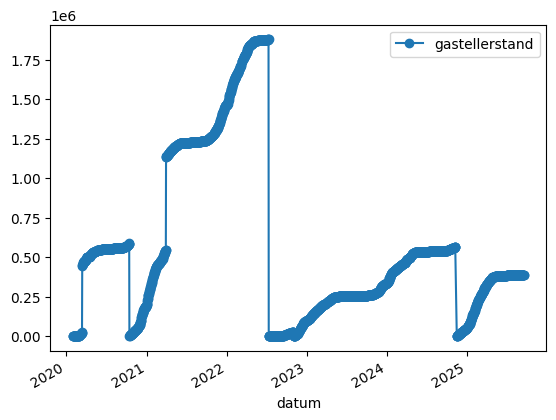

In [ ]:
gasteller.plot(marker='o')

**Kan je al fouten zien?**

Er zitten grote sprongen in de data, zowel naar boven als naar beneden.

### Tellerdata opschonen

Tellerdata bevatten vaak onregelmatigheden. Typische problemen:
- **Resets**: teller springt terug naar 0 ⇒ negatieve verbruiken bij verschilname.
- **Uitschieters (spikes)**: foutieve pieken door meetfouten.
- (Optioneel) **Ontbrekende of dubbele tijdstippen**.
- **Meetruis**: kleine schommelingen die de trend vertroebelen.

#### Aanpak in stappen
1) **Zet tellerstand om naar verbruik**  
   - Bereken het verschil tussen opeenvolgende dagen (`diff()`): verbruik = stand(t) − stand(t−1).  
   - Dit maakt resets en pieken zichtbaar in plaats van verborgen in de tellerstand.

2) **Resets wegwerken (negatieve verbruiken)**  
   - Zet negatieve waarden op 0 (bv. via `clip(lower=0)`), zodat reset‑effecten geen negatief verbruik veroorzaken.

3) **Uitschieters detecteren en behandelen**  
   - Kies een **drempel (drempelwaarde)** op basis van domeinkennis (bv. maximaal realistisch dagverbruik) of gebruik een robuuste methode (bv. **IQR‑regel** of **rolling z‑score**).  
   - Behandel outliers:  
     - op 0 zetten (conservatief),  
     - vervangen door een **lokaal gemiddelde/median** (bv. rolling window), of  
     - als `NaN` markeren en **interpoleren**.  
   - De keuze hangt af van het doel (analyse vs. rapportering) en moet consistent en transparant zijn.

4) (Optioneel) **Ruis verminderen**  
   - Gebruik een **voortschrijdend gemiddelde** of **rolling median** om trends duidelijker te maken zonder echte signalen te verbergen.

5) **Valideren en documenteren**  
   - Visualiseer tellerstand én verbruik voor/na opschoning.  
   - Noteer aannames, drempels en gekozen strategieën zodat resultaten reproduceerbaar zijn.

Tip: test de gevoeligheid van je conclusies voor de gekozen drempel en methode (scenario’s met lage/hoge drempel).

#### Gasverbruiken destileren

Dit kan heel gemakkelijk met `gasteller.diff()`.

In [4]:
# 1. Maak een nieuwe variable met gasverbruik en zet deze gelijk aan de differentieel van de tellerstanden en controleer het resultaat
gasverbruik = gasteller.diff().rename(columns={'gastellerstand': 'gasverbruik'})

# 2. visualiseer het resultaat maar let op de kolomnamen!
gasverbruik.head()

,gasverbruik
datum,
2020-02-01,NaN
2020-02-02,0.0
2020-02-03,0.0
2020-02-04,0.0
2020-02-05,0.0


Voor de eerste dag hebben we `NaN` wat normaal is, maar ook de eerste standen zijn $0$, wat waarschijnlijk ook foute data is, aangezien het nog winter is, en de gasteller dus zou moeten draaien. Laten we deze data preventief verwijderen tot de eerste echte waarde.

In [5]:
# 1. verwijder lege waarden met `dropna`
gasverbruik = gasverbruik.dropna()

# 2. Spoor de eerste datum met een waarde groter dan 0 op en bewaar deze datum in een variabele
# eerste datum met niet-nul verbruik
series = gasverbruik.copy()
first_date = series.replace(0, np.nan).first_valid_index()
if first_date is None:
    raise ValueError("Geen niet-nul verbruiken gevonden.")

# knip alles ervoor weg
gasverbruik = gasverbruik.loc[first_date:]
gasteller   = gasteller.loc[first_date:]

gasverbruik.head()

,gasverbruik
datum,
2020-02-29,2141.0
2020-03-01,2536.0
2020-03-02,2364.0
2020-03-03,2436.0
2020-03-07,5341.0


Laten we het verbruik eerst eens visualiseren

<Axes: xlabel='datum'>

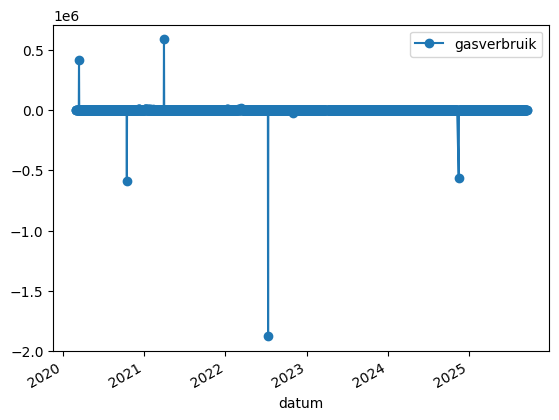

In [6]:
gasverbruik.plot(marker='o')

Wanneer je kijkt naar de grafiek zie je duidelijk uitschieters naar onder, en naar boven. Eerst halen we de uitschieters naar onder weg, dit is het makkelijkste.

<Axes: xlabel='datum'>

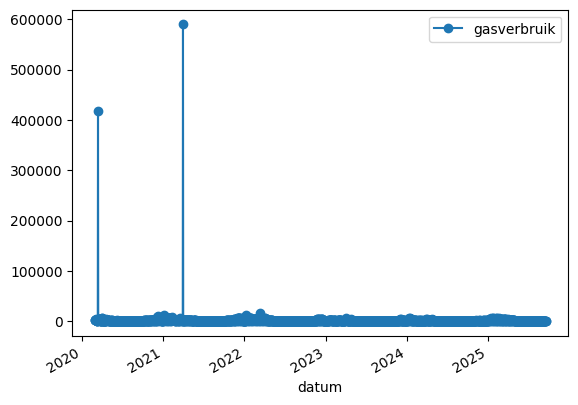

In [7]:
# 1. Zet alle rijen waarbij het gasverbruik kleiner is dan 0 op 0
gasverbruik[gasverbruik < 0] = 0

# 2. Plot nogmaals het verbruik
gasverbruik.plot(marker='o')

Nu kunnen we nog 2 uitschieters naar boven dedecteren. Bepaal een treshold, en verwijder deze waarden.

**Gekozen treshold**: 1000000

<Axes: xlabel='datum'>

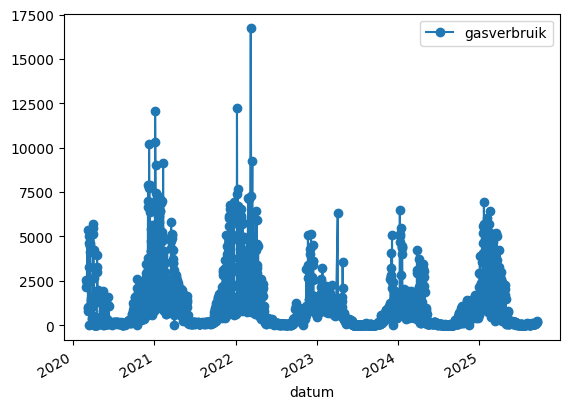

In [8]:
# 1. verwijder alle waarden groter dan de treshold en zet deze op 0
gasverbruik[gasverbruik > 10_0000] = 0

# 2. Plot nog eens het resultaat
gasverbruik.plot(marker='o')

### Gezond verstand

Deze stap is waarschijnlijk de gevaarlijkste stap, waarbij we de data gaan beoordelen en de waarden goed bekijken. Wanneer we kijken naar de maximum waarde, zien we dat we aan $17500$ zitten. Aangezien het hier gaat om een `gasteller` kunnen we er van uitgaan dat het gaat om $m³$. Echter lijkt dit voor ons gekozen gebouw toch vrij hoog. Wat zou er kunnen foutgelopen zijn.

**Oplossing**: We geven hier de oplossing mee, bij het exporteren van de data van het gbs, valt de komma weg, het gbs houdt de tellerstanden bij tot 2 cijfers na de komma, en deze viel weg. Om om te zetten in $m³$ moeten we de data dus delen door 100, wat gelukkig gemakkelijk gaat in python!

In [9]:
gasverbruik = gasverbruik / 100
gasteller = gasteller / 100

> Pas op ben bovenstaande cel. Telkens je deze uitvoert wordt het verbruik verder gedeeld door 100. Deze cel kan je dus maar 1 keer uitvoeren. Wanneer je deze per ongeluk 2 keer uitvoert zal je opnieuw van het begin de dataset moeten inladen om juiste waarden te krijgen (of eens vermenigvuldigen met 100).

Eigenlijk willen we ook onze verbruiken zien in $kWh$. Hiervoor moeten we onze waarden vermenigvuldigen met een factor van $11.4$, aangezien het om hoogcalorisch gas gaat. Indien je echt heel diep wilt gaan, kan je ook een dataset bij elkaar zoeken met de exacte waarde per dag (maand) die gepubliceerd wordt door fluvius, er is echter veel opruimwerk aan, en de variatie is miniem (tussen $11.40$ en $11.46$).

In [10]:
gasverbruik_kwh = gasverbruik * 11.4

Laten we de curve eens goed uitzetten en bekijken!

<Axes: xlabel='datum'>

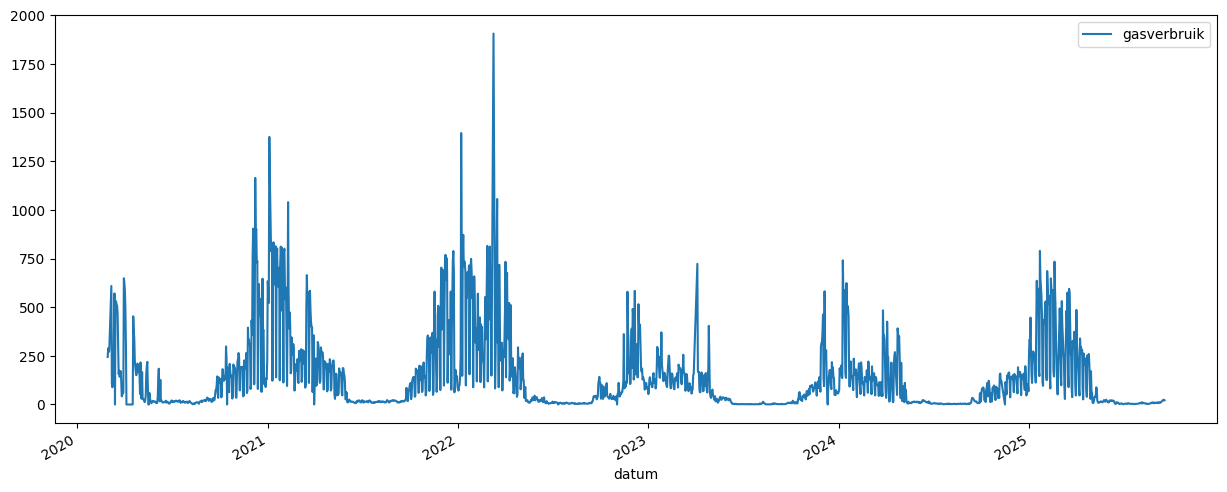

In [11]:
gasverbruik_kwh.plot(figsize=(15,6))

Bij een eerste _visuele_ analyse kunnen we duidelijk iets herkennen wat waarschijnlijk winter zal zijn. Ook kunnen we zien dat er eigenlijk nooit echt een periode geen verbruik is. Wordt deze gasketel dat enkel gebruikt voor verwarming?

Een 2de duidelijke trend lijkt dat er ergens in de zomer van 2022 iets moet gebeurd zijn?  
Een 3de trend kunnen we in de laatste winter zien, waar er ergens iets voor het midden iets moet gebeurd zijn?

Kan je het kerstverlof ook spotten in de curve?

## Stap 2: Calorieteller

### Inladen van de data
Laten we nu de calorieteller inladen!

In [12]:
# 1. laad de calorietellerdata in (data/gasketel_warm.txt), seperator is een tap (sep='\t") en laat de header (titel kolomen) weg
calorieteller = pd.read_csv('data/calorieteller_gasketel.txt', sep='\t', header=0)

# 2. Hernoem de kolommen naar datum en calorieteller en verwijder de laatste kolom indien nodig
calorieteller = calorieteller.iloc[:, :2]
calorieteller.columns = ['datum', 'gasketel_opbrengst']

# 3. Zet de datumkolom om naar een datetime object
calorieteller.datum = pd.to_datetime(
    calorieteller['datum'].str.split(',').str[0],  # neem alles vóór de komma
    format='%m/%d/%y',
    errors='coerce'
)

# 4. Zet de datum als index
calorieteller = calorieteller.set_index('datum')


# 5. controleer het resultaat
calorieteller.head()

,gasketel_opbrengst
datum,
2020-05-29,7922072.0
2020-05-30,7922072.0
2020-05-31,7922177.0
2020-06-01,7922177.0
2020-06-02,7922177.0


<Axes: xlabel='datum'>

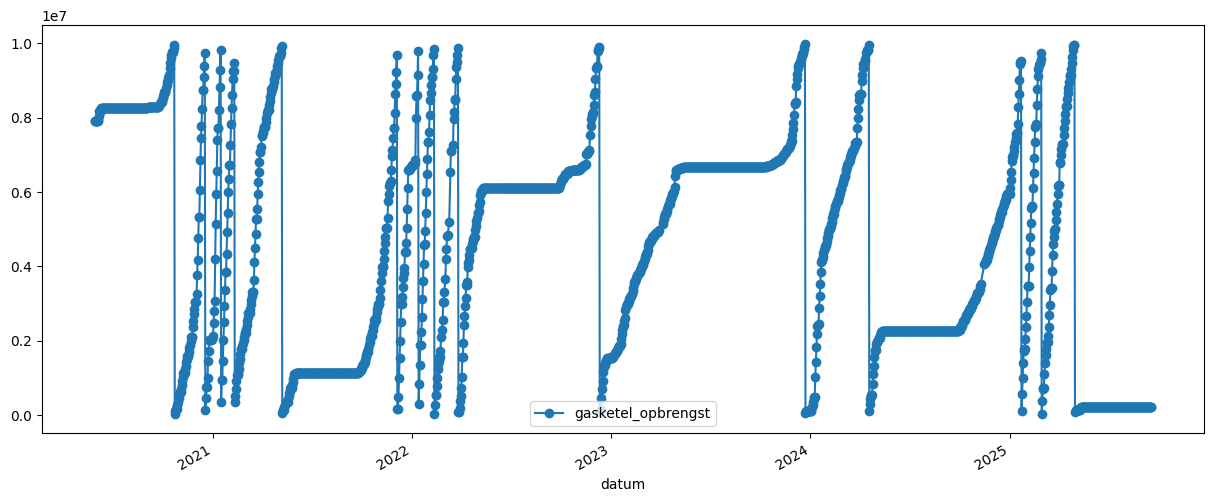

In [13]:
# Visualiseer
calorieteller.plot(marker='o', figsize=(15,6))

Hier kunnen we een ander beeld zien als de vorige keer, ook hier zal het belangrijk zijn om te blijven zoeken en nadenken.

**Sterk vermoeden**: We zien hier dat de tellerstand een **rollover** (overloop) vertoont bij $10.000.000~\text{Wh}$, waarbij de teller terugspringt naar $0$. 

**Probleem voor dagverbruiken:**  
Bij het berekenen van dagelijkse verschillen (`diff()`) ontstaan **kunstmatig negatieve waarden** rond de rollover:
- **Dag vóór rollover**: Tellerstand staat net onder 10.000.000 Wh
- **Dag van rollover**: Tellerstand springt naar ~0 Wh → `diff()` berekent een groot **negatief** dagverbruik
- **Dag ná rollover**: Eerste echte waarde na reset, maar onbetrouwbaar door timing-effecten

**Aanpak:**  
We markeren dagen met **negatieve verbruiken** (indicatie van rollover) als `NaN` om foutieve berekeningen te vermijden. Dit resulteert in een kleine data-gap, maar voorkomt grote vertekening van statistieken en gemiddelden.

Zet opnieuw de tellerstand om naar een dag differentieel. Ga daar na of er negatieve waarden zijn, en verwijder deze.

In [14]:
# Robuuste rollover-correctie (vectorieel)
ROLLOVER_MAX = 10_000_000  # zet hier de meter-max (Wh)

s = calorieteller['gasketel_opbrengst'].astype(float)
diff = s.diff()
prev = s.shift(1)

# aantal mogelijke wraps tussen metingen (ceil), werkt ook als er >1 wrap is
n_wraps = np.ceil((prev - s) / ROLLOVER_MAX).fillna(0).astype(int)
n_wraps = n_wraps.where(n_wraps > 0, 0)

# gecorrigeerde diff waar we een wrap detecteren
corrected = diff + n_wraps * ROLLOVER_MAX

# acceptatiecriterium: ofwel we berekenden >=1 wrap, of de vorige waarde zat erg dicht bij de max
maybe_rollover = (n_wraps >= 1) | (prev > 0.8 * ROLLOVER_MAX)

diff_corrected = diff.copy()
# pas correctie toe waar diff < 0 en we een rollover aannemen
mask_neg = diff < 0
apply_mask = mask_neg & maybe_rollover
diff_corrected[apply_mask] = corrected[apply_mask]

# overige negatieve diffs markeren als NaN (meetfout)
diff_corrected[mask_neg & ~maybe_rollover] = np.nan

# resultaat als DataFrame (dagverbruik Wh) en conversie naar kWh
dag_opbrengst = diff_corrected.to_frame(name='gasketel_opbrengst_wh')
dag_opbrengst['gasketel_opbrengst_kwh'] = dag_opbrengst['gasketel_opbrengst_wh'] / 1000.0

print(f"Detected negative diffs: {mask_neg.sum()}, corrected rollovers: {apply_mask.sum()}, remaining NaN: {dag_opbrengst['gasketel_opbrengst_wh'].isna().sum()}")

Detected negative diffs: 15, corrected rollovers: 15, remaining NaN: 1


<Axes: xlabel='datum'>

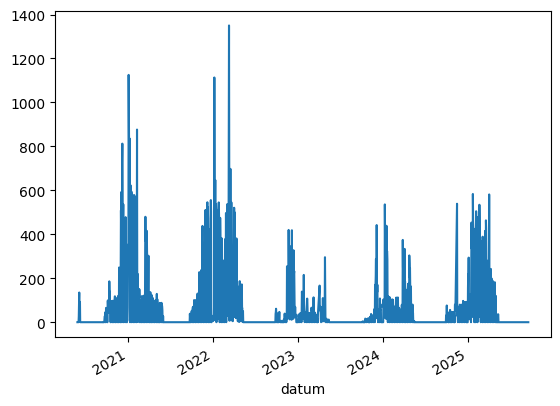

In [15]:
dag_opbrengst['gasketel_opbrengst_kwh'].plot()

### Controle datasets

We hebben nu de 2 datasets ingelezen en opgeschoond. Laten we ze eerst **visueel controleren** door ze over elkaar te leggen voordat we het rendement berekenen.

#### Stap 1: Datasets aligneren en visualiseren

We maken eerst een nieuwe dataset met het gasverbruik en de opgewekte warmte. Een mogelijke manier is om eerst 1D series te maken en een date-time index, om dan deze samen te voegen.

We gebruiken hiervoor `join='inner'`. Op die manier combineren we de 2 dataframes, en houden enkel de data's (index) over die in beide dataframes voorkomen. Er zijn ook nog andere types, zie het figuurtje hieronder.

![](img/pandas_join_types.jpg)  

_Bron: www.educba.com_

In [16]:
opbrengst = dag_opbrengst['gasketel_opbrengst_kwh'].rename('opbrengst_kwh')
gv = gasverbruik_kwh['gasverbruik'].rename('gasverbruik_kwh')

rendement_gasketel = pd.concat([gv, opbrengst], axis=1, join='inner')
rendement_gasketel = rendement_gasketel.dropna()

print(rendement_gasketel.head())
print(rendement_gasketel.describe())

            gasverbruik_kwh  opbrengst_kwh
datum                                     
2020-05-30           15.390          0.000
2020-05-31           10.032          0.105
2020-06-01            8.208          0.000
2020-06-02            8.436          0.000
2020-06-03            7.524          0.000
       gasverbruik_kwh  opbrengst_kwh
count      1914.000000    1914.000000
mean        137.674536      74.341914
std         195.539463     142.886646
min           0.000000       0.000000
25%          11.400000       0.000000
50%          60.990000       0.000000
75%         172.938000      76.105750
max        1905.966000    1350.183000


Laten we onze nieuwe dataset eerst plotten.

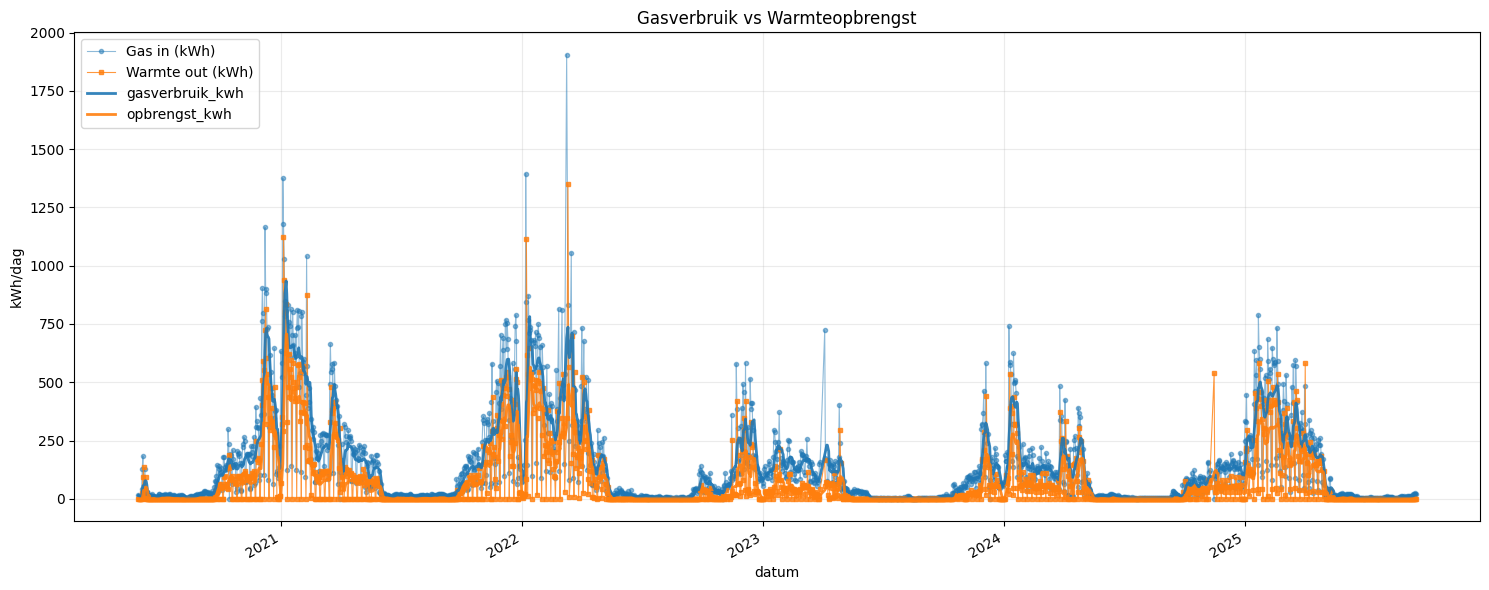

In [17]:
fig, ax = plt.subplots(figsize=(15,6))

# Plot ruwe punten met transparantie en kleine markers
rendement_gasketel['gasverbruik_kwh'].plot(
    ax=ax, color='C0', alpha=0.5, marker='o', markersize=3, linewidth=0.8, label='Gas in (kWh)'
)
rendement_gasketel['opbrengst_kwh'].plot(
    ax=ax, color='C1', alpha=0.8, marker='s', markersize=3, linewidth=0.8, label='Warmte out (kWh)'
)

# Optioneel: 7‑daags rolling mean om trends zichtbaar te maken
rendement_gasketel[['gasverbruik_kwh','opbrengst_kwh']].rolling(7, min_periods=1).mean().plot(
    ax=ax, linewidth=2, alpha=0.9, style=['C0-','C1-']
)

ax.set_ylabel('kWh/dag')
ax.set_title('Gasverbruik vs Warmteopbrengst')
ax.grid(alpha=0.25)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

Laten we eerst kijken wat het gemiddelde rendement is van de ketel over de hele periode!

In [18]:
print('RAPPORT RENDEMENT GASKETEL')
print(f'Periode: {rendement_gasketel.index.min()} tot {rendement_gasketel.index.max()}')
print()
print(f'Totaal gasverbruik: {rendement_gasketel['gasverbruik_kwh'].sum():.2f} kwh')
print(f'Totale opbrengst in kwh: {rendement_gasketel['opbrengst_kwh'].sum():.2f} kwh')
print(f"Totaal gemiddeld rendement: {rendement_gasketel['opbrengst_kwh'].sum() / rendement_gasketel['gasverbruik_kwh'].sum():.2%}")

RAPPORT RENDEMENT GASKETEL
Periode: 2020-05-30 00:00:00 tot 2025-09-17 00:00:00

Totaal gasverbruik: 263509.06 kwh
Totale opbrengst in kwh: 142290.42 kwh
Totaal gemiddeld rendement: 54.00%


Dit geeft een indicatie dat het niet zo goed gaat met ons rendement. Dagrendementen berekenen heeft weinig zin door de vele meetfouten. Maar we kunnen onze dataset wel aggregeren per maand, en zien of we maand over maand verschillen zien. 

In [19]:
rendement_gasketel_maand = rendement_gasketel.resample('MS').sum()

# maandrendement = totale maandopbrengst / totaal maangas
rendement_gasketel_maand['rendement_maand'] = (
    rendement_gasketel_maand['opbrengst_kwh'] / rendement_gasketel_maand['gasverbruik_kwh']
)

<Axes: xlabel='datum'>

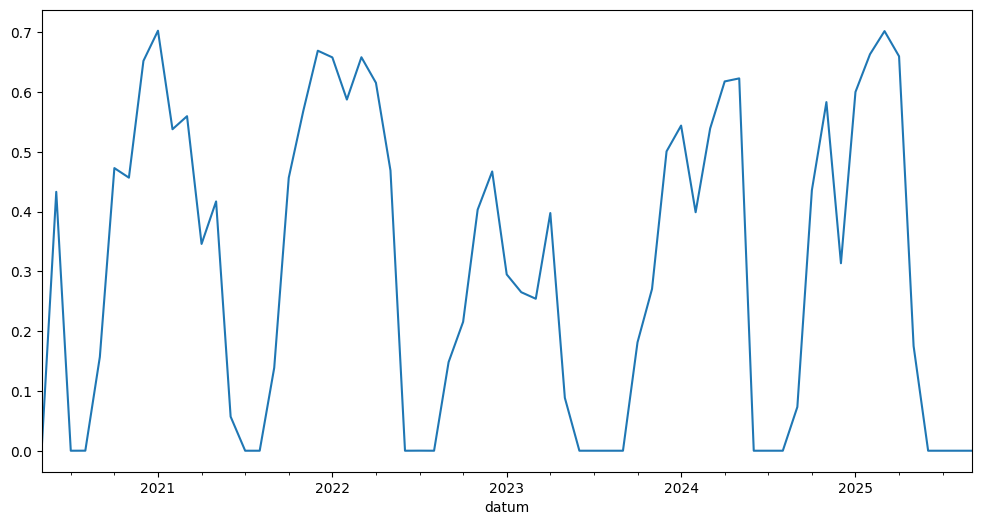

In [20]:
rendement_gasketel_maand['rendement_maand'].plot(figsize=(12,6))

## Extra oefening: Maandelijkse graaddagen‑analyse

**Heating Degree Days (HDD / graaddagen)** kwantificeren de potentiële verwarmingsvraag op basis van buitentemperatuur. Meer graaddagen = kouder weer = hogere verwachte warmtevraag. We koppelen dit aan het gasketelrendement om te zien hoe efficiënt de ketel presteert naarmate de vraag stijgt.

### Doel
- Relatie tonen tussen maandelijkse verwarmingsvraag (HDD som per maand) en maandrendement.
- Trend schatten (lineaire regressie) en eenvoudige correlatiemeting.
- Maanden vergelijken (winter vs tussenseizoen vs zomer) voor interpretatie.

### Wat we gaan doen
1. Dagdatasets afronden: dagelijks rendement (en eventueel 7d smooth) + dagelijkse graaddagen.
2. Resamplen naar maandniveau:
   - Graaddagen: som per maand (`resample('MS').sum()`).
   - Gas en warmte: som per maand (bestaat al in `rendement_gasketel_maand`).
   - Rendement per maand: output / input.
3. Samenvoegen in één DataFrame (inner join op maandindex).
4. Visualisaties:
   - Scatter: maandrendement (%) vs maandelijkse HDD.
   - Regressielijn + vergelijking: y = m * HDD + b (m = verandering rendement per extra HDD).
   - Annotatie van maanden (YYYY-MM) voor context.

### Uitbreiding (optioneel)
- Tweede model met alleen wintermaanden.
- Niet‑lineair (bv. log of piecewise) indien duidelijke buiging.
- Analyse op 7‑daags rendement vs maandelijkse gemiddelde HDD/dag.

### Stap 1 - Data inlezen

Onze dataset bevindt zich: `data/graaddagen.txt`.

Probeer dit zelf op de zelfde manier zoals we de gasverbruiken en calorieteller hebben ingeladen.

- We laden de data in en laten de header weg.
- We hernoemen de kolommen
- We zetten de datum kolom om naar een datetime en zetten het als index
- We plotten de data

> **TIP**: Gebruik `errors='coerce'` om fouten over te slaan

In [21]:
graaddagen = pd.read_csv(
    'data/graaddagen.txt',
    sep='\t',
    header=None,
    names=['datum', 'graaddag']
)

graaddagen['graaddag'] = pd.to_numeric(graaddagen['graaddag'], errors='coerce')
graaddagen['datum'] = pd.to_datetime(graaddagen['datum'], errors='coerce')

graaddagen = (
    graaddagen.dropna(subset=['datum', 'graaddag'])
              .set_index('datum')
              .sort_index()
)

graaddagen.head()

,graaddag
datum,
2020-03-01,9.6
2020-03-02,10.2
2020-03-03,11.7
2020-03-04,11.4
2020-03-05,10.6


### Stap 2 en 3 - Resampelen naar maand en in 1 dataset stoppen

Laten we nu de graaddagen per maand nemen (som van alle graaddagen die maand) en deze toevoegen aan ons rendement dataframe.

In [22]:
# Maandelijkse graaddagen berekenen
graaddagen_maand = graaddagen.resample('MS').sum()  # index = eerste dag maand

# Kolomnaam duidelijk maken
graaddagen_maand = graaddagen_maand.rename(columns={'graaddag': 'graaddagen_maand'})

# Alleen maanden behouden die al in rendement_gasketel_maand zitten
rendement_gasketel_maand['graaddagen_maand'] = (
    graaddagen_maand['graaddagen_maand'].reindex(rendement_gasketel_maand.index)
)

rendement_gasketel_maand.head()


,gasverbruik_kwh,opbrengst_kwh,rendement_maand,graaddagen_maand
datum,,,,
2020-05-01,25.422,0.105,0.004130,87.0
2020-06-01,814.302,352.822,0.433282,25.4
2020-07-01,456.342,0.000,0.000000,2.8
2020-08-01,331.968,0.023,0.000069,4.0
2020-09-01,1306.782,205.153,0.156991,32.0


### Stap 4 - Visualisatie

We willen weten of er een correlatie is, we kunnen dit snel checken door alle kolommen te herschalen naar een schaal tussen 0 en 1, en dan kunnen we zien waar de correlaties liggen.

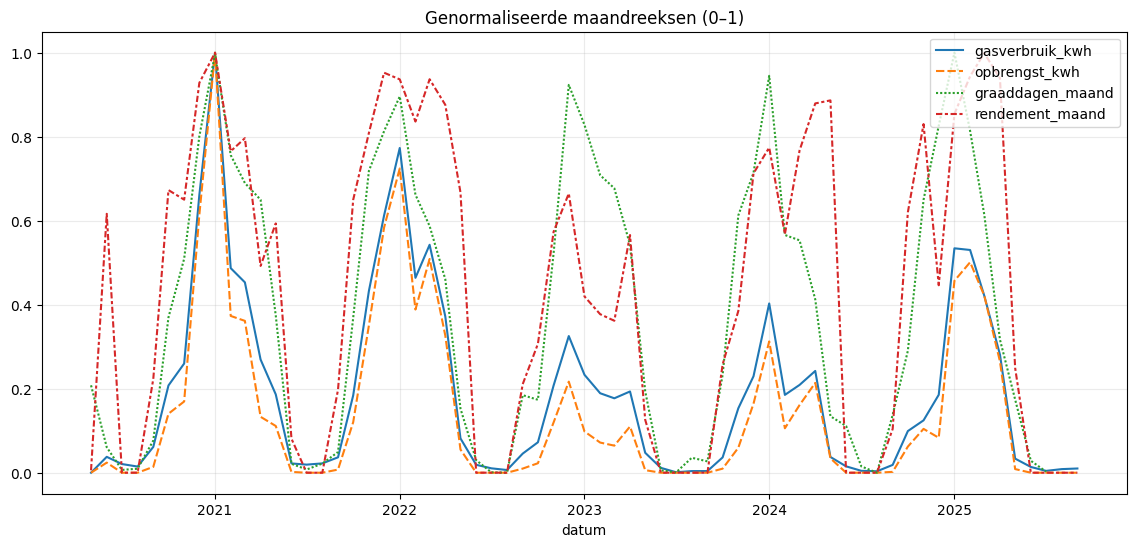

In [39]:
# Min-max herschalen (0–1) van relevante kolommen
cols = ['gasverbruik_kwh','opbrengst_kwh','graaddagen_maand','rendement_maand']
df = rendement_gasketel_maand[cols].copy()
denom = df.max() - df.min()
denom[denom == 0] = 1  # voorkom delen door 0
df_scaled = (df - df.min()) / denom

plt.figure(figsize=(14,6))
sns.lineplot(data=df_scaled)
plt.title('Genormaliseerde maandreeksen (0–1)')
plt.grid(alpha=0.25); plt.legend(loc='upper right')

Hieruit kunnen we nog niet veel opmaken. Laten we nu volgende visualisaties maken:

- Scatter: maandrendement (%) vs maandelijkse HDD.
- Regressielijn + vergelijking: y = m * HDD + b (m = verandering rendement per extra HDD).
- Annotatie van maanden (YYYY-MM) voor context.

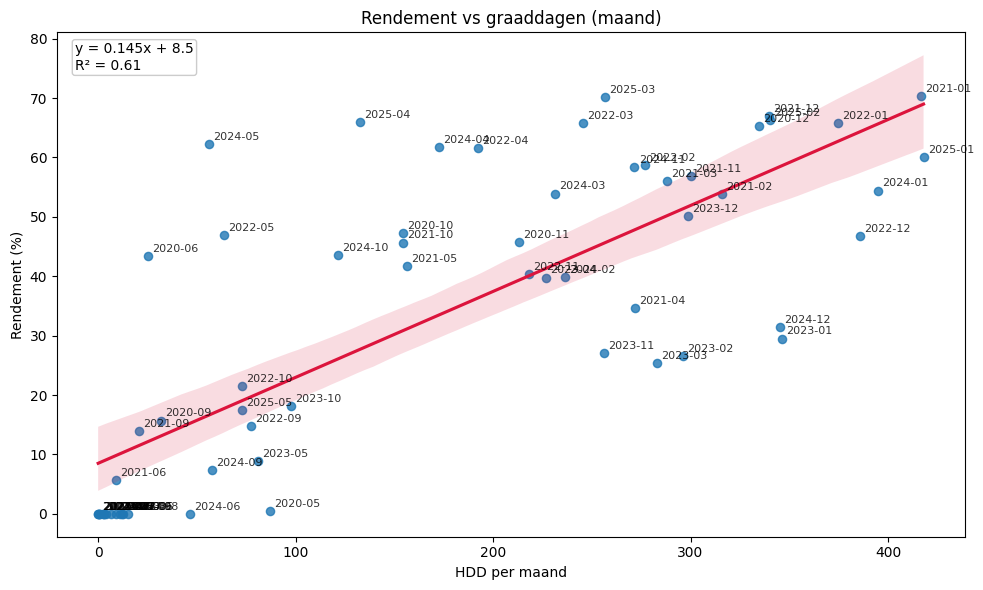

In [41]:
df_vis = rendement_gasketel_maand[['graaddagen_maand', 'rendement_maand']].dropna()
x, y = df_vis['graaddagen_maand'], df_vis['rendement_maand'] * 100
m, b = np.polyfit(x, y, 1)
r2 = np.corrcoef(x, y)[0,1]**2

plt.figure(figsize=(10,6))
ax = sns.regplot(x=x, y=y, scatter_kws={'s':35}, line_kws={'color':'crimson'})
for xx, yy, lab in zip(x, y, df_vis.index.strftime('%Y-%m')): ax.annotate(lab, (xx, yy), textcoords='offset points', xytext=(3,3), fontsize=8, alpha=0.8)
ax.set(title='Rendement vs graaddagen (maand)', xlabel='HDD per maand', ylabel='Rendement (%)')
ax.text(0.02, 0.98, f'y = {m:.3f}x + {b:.1f}\nR² = {r2:.2f}', transform=ax.transAxes, va='top', ha='left',
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='0.8'))
plt.tight_layout()

-------------------

EINDE

---------------------